This notebook contains only the implementations of transfer learning using ResNet50 and VGG16 models.

In [ ]:
import pandas as pd
import random
import tensorflow as tf
from PIL import Image
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


here, I have stored the data.zip file in my google drive and unzipped it directly here on the colab with the name **project_data** since the data file was pretty huge.

In [ ]:
!unzip -d project_data /content/drive/Shareddrives/shared_drive/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: project_data/data/ESP_032207_1350_5120_10240_0_5120/labels/background/ESP_032207_1350_5120_5419_4485_4784.json  
  inflating: project_data/__MACOSX/data/ESP_032207_1350_5120_10240_0_5120/labels/background/._ESP_032207_1350_5120_5419_4485_4784.json  
  inflating: project_data/data/ESP_032207_1350_5120_10240_0_5120/labels/background/ESP_032207_1350_5419_5718_1196_1495.json  
  inflating: project_data/__MACOSX/data/ESP_032207_1350_5120_10240_0_5120/labels/background/._ESP_032207_1350_5419_5718_1196_1495.json  
  inflating: project_data/data/ESP_032207_1350_5120_10240_0_5120/labels/background/ESP_032207_1350_5718_6017_4784_5083.json  
  inflating: project_data/__MACOSX/data/ESP_032207_1350_5120_10240_0_5120/labels/background/._ESP_032207_1350_5718_6017_4784_5083.json  
  inflating: project_data/data/ESP_032207_1350_5120_10240_0_5120/labels/background/ESP_032207_1350_6914_7213_4186_4485.json  
  inflating: project_data/__MACOSX

In [ ]:
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./project_data/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]


In [ ]:
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [ ]:
def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')

        # img = tf.image.random_brightness(img, max_delta=0.2)
        # img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        # img = tf.image.rot90(img, k=1)

        img = np.array(img)
        img = tf.image.resize(img, [299, 299])
        img = img / 255.0
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        return img, label


    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    X.set_shape([299, 299, 3])
    y.set_shape([])

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

## ResNet50

Epoch 1/10
928/928 [==============================] - 475s 493ms/step - loss: 0.5178 - accuracy: 0.7465 - val_loss: 3.9933 - val_accuracy: 0.6782
Epoch 2/10
928/928 [==============================] - 447s 481ms/step - loss: 0.4780 - accuracy: 0.7726 - val_loss: 7.8728 - val_accuracy: 0.3218
Epoch 3/10
928/928 [==============================] - 470s 506ms/step - loss: 0.4681 - accuracy: 0.7806 - val_loss: 3.8883 - val_accuracy: 0.3218
Epoch 4/10
928/928 [==============================] - 465s 501ms/step - loss: 0.4613 - accuracy: 0.7846 - val_loss: 0.7312 - val_accuracy: 0.8058
Epoch 5/10
928/928 [==============================] - 437s 471ms/step - loss: 0.4594 - accuracy: 0.7836 - val_loss: 2.0004 - val_accuracy: 0.6826
Epoch 6/10
928/928 [==============================] - 436s 469ms/step - loss: 0.4537 - accuracy: 0.7881 - val_loss: 12.2946 - val_accuracy: 0.3218
Epoch 7/10
928/928 [==============================] - 439s 473ms/step - loss: 0.4522 - accuracy: 0.7905 - val_loss: 0.2457 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


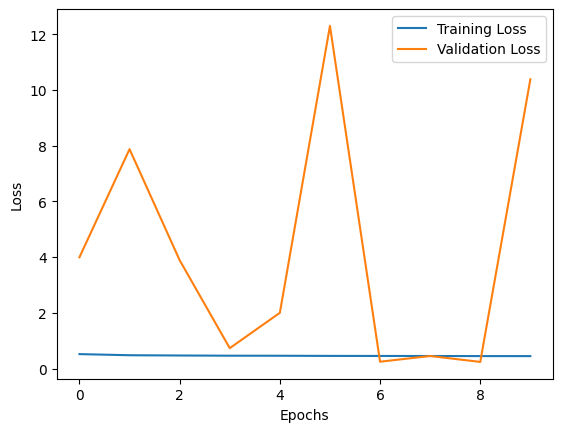

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299,299,3))

for layer in base_model.layers[:-1]:
  layer.trainable = False

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(tf_dataset_train, epochs=10, validation_data=tf_dataset_val, callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(tf_dataset_test)

y_true_list = []
y_pred_list = []

for batch in tf_dataset_test:
    X_batch, y_true_batch = batch

    y_pred_batch = model.predict(X_batch)
    y_pred_classes_batch = np.argmax(y_pred_batch, axis=1)

    y_true_list.extend(y_true_batch.numpy())  # Assuming y_true_batch is a TensorFlow tensor
    y_pred_list.extend(y_pred_classes_batch)

# Convert lists to NumPy arrays for further analysis
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

# Calculate classification metrics
classification_rep = classification_report(y_true, y_pred)
print(classification_rep)

# Plot Training and Validation Errors
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## VGG16

Epoch 1/10
928/928 [==============================] - 604s 630ms/step - loss: 0.3701 - accuracy: 0.8293 - val_loss: 0.8471 - val_accuracy: 0.6254
Epoch 2/10
928/928 [==============================] - 515s 555ms/step - loss: 0.3143 - accuracy: 0.8567 - val_loss: 1.0501 - val_accuracy: 0.5752
Epoch 3/10
928/928 [==============================] - 525s 566ms/step - loss: 0.3047 - accuracy: 0.8644 - val_loss: 0.4186 - val_accuracy: 0.8216
Epoch 4/10
928/928 [==============================] - 517s 557ms/step - loss: 0.2925 - accuracy: 0.8706 - val_loss: 0.3946 - val_accuracy: 0.8366
Epoch 5/10
928/928 [==============================] - 513s 552ms/step - loss: 0.2913 - accuracy: 0.8730 - val_loss: 0.2301 - val_accuracy: 0.9084
Epoch 6/10
928/928 [==============================] - 513s 553ms/step - loss: 0.2900 - accuracy: 0.8721 - val_loss: 0.6841 - val_accuracy: 0.7135
Epoch 7/10
928/928 [==============================] - 515s 555ms/step - loss: 0.2865 - accuracy: 0.8723 - val_loss: 1.1220 -

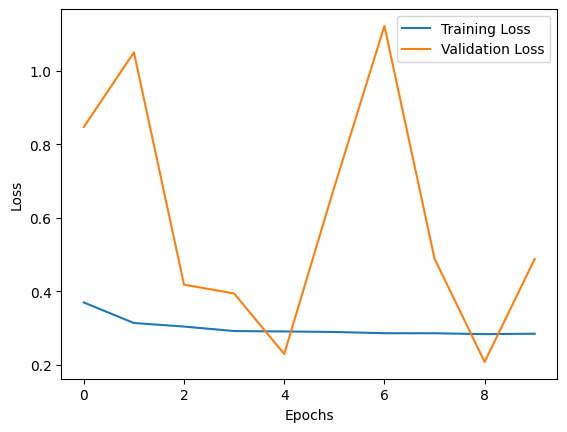

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(299,299,3))

for layer in base_model.layers[:-1]:
  layer.trainable = False

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(tf_dataset_train, epochs=10, validation_data=tf_dataset_val, callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(tf_dataset_test)

y_true_list = []
y_pred_list = []

for batch in tf_dataset_test:
    X_batch, y_true_batch = batch

    y_pred_batch = model.predict(X_batch)
    y_pred_classes_batch = np.argmax(y_pred_batch, axis=1)

    y_true_list.extend(y_true_batch.numpy())  # Assuming y_true_batch is a TensorFlow tensor
    y_pred_list.extend(y_pred_classes_batch)

# Convert lists to NumPy arrays for further analysis
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

# Calculate classification metrics
classification_rep = classification_report(y_true, y_pred)
print(classification_rep)

# Plot Training and Validation Errors
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


##Compare the results of transfer learning with those of CNN + MLP model and explain them


* Transfer learning with **VGG16** appears to be the most successful among the models I've tried, showing high accuracy and balanced performance for both classes.
* The **CNN+MLP model**, while not as efficient as **VGG16**, still performs well and may have benefits, especially if computational resources are a concern.
* **EfficientNetB0** struggles to capture the complexity of the data, resulting in poor performance, especially for Class 1.
* **ResNet50** shows decent accuracy but has challenges correctly predicting instances of Class 0.
* In conclusion, the choice of the model depends on the specific requirements, including computational resources, dataset size, and the importance of precision and recall for our specific application. **VGG16** seems to be a strong candidate based on the provided results.